# WASTE MANAGEMENT

PROBLEM

Waste management is a big problem in our country. Most of the wastes end up in landfills. This leads to many issues like

* Increase in landfills
* Eutrophication
* Consumption of toxic waste by animals
* Increase in toxins
* Land, water and air pollution

APPROACH

* Analysed the components of household waste
* Segregated into two classes (Organic and recyclable)
* Automated the process by using IOT and machine learning
* Reduce toxic waste ending in landfills

### IMPORT LIBRARIES

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import skimage.io
import tensorflow 
import tqdm
import glob

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline

### IMPORT DATASET 

> `TRAINING IMAGES`

In [2]:
train_o = glob.glob('../input/waste-classification-data/DATASET/TRAIN/O/*.jpg')
a = len(train_o)

In [3]:
train_r = glob.glob('../input/waste-classification-data/DATASET/TRAIN/R/*.jpg')
b = len(train_r)

In [4]:
# Total training images 

print("Nos of training samples: {}".format(a+b))

Nos of training samples: 22564


> `DATA AUGMENTATION`

In [5]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/waste-classification-data/DATASET/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128, 
                                                   subset = 'training')

Found 18052 images belonging to 2 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/waste-classification-data/DATASET/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128, 
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


In [8]:
# Class Indices 

train_dataset.class_indices

{'O': 0, 'R': 1}

100%|██████████| 5/5 [00:19<00:00,  3.87s/it]


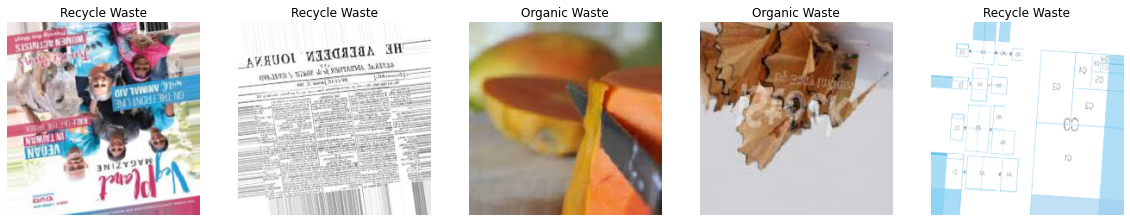

In [9]:
# Viewing Images

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(128)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('Recycle Waste')
    else:
        ax[i].set_title('Organic Waste')

### MODEL BUILDING

In [10]:
import os

In [11]:
# Get the absolute path of the weights file
weights_path = os.path.abspath("/kaggle/input/vggweights/vgg16_weights_tf_dim_ordering_tf_kernels_notop (1).h5")

# Define the VGG16 model with custom weights
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights=weights_path)

In [12]:
# Freezing Layers 

for layer in base_model.layers:
    layer.trainable=False

In [13]:
# Summary

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
# Defining Layers

model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [15]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0

In [16]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [17]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [18]:
# Model Fitting 

model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/10
142/142 [==============================] - ETA: 0s - loss: 0.3489 - auc: 0.9291
Epoch 00001: val_auc improved from -inf to 0.95186, saving model to ./best_weights.hdf5
142/142 [==============================] - 393s 3s/step - loss: 0.3489 - auc: 0.9291 - val_loss: 0.2986 - val_auc: 0.9519
Epoch 2/10
142/142 [==============================] - ETA: 0s - loss: 0.2647 - auc: 0.9567
Epoch 00002: val_auc did not improve from 0.95186
142/142 [==============================] - 264s 2s/step - loss: 0.2647 - auc: 0.9567 - val_loss: 0.2884 - val_auc: 0.9503
Epoch 3/10
142/142 [==============================] - ETA: 0s - loss: 0.2432 - auc: 0.9634
Epoch 00003: val_auc did not improve from 0.95186
142/142 [==============================] - 264s 2s/step - loss: 0.2432 - auc: 0.9634 - val_loss: 0.3123 - val_auc: 0.9433
Epoch 4/10
142/142 [==============================] - ETA: 0s - loss: 0.2258 - auc: 0.9684
Epoch 00004: val_auc did not improve from 0.95186
142/142 [=======================

### MODEL EVALUATION

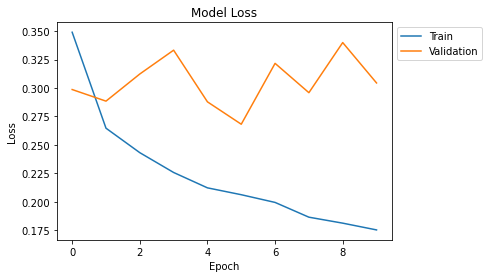

In [19]:
# Summarize the model loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

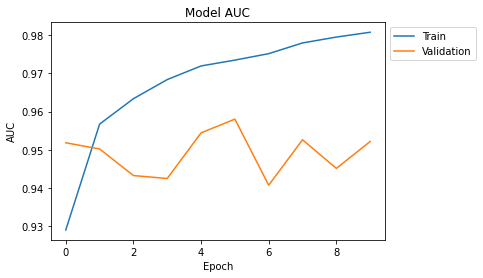

In [20]:
# Summarize models auc

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [21]:
# Test Data 

test_data = test_datagen.flow_from_directory(directory = '../input/waste-classification-data/DATASET/TEST',
                                             target_size = (224,224),
                                             class_mode = 'binary',
                                             batch_size = 128)

Found 2513 images belonging to 2 classes.


In [22]:
# Evaluating Loss and AUC - Test Data 


model.evaluate(test_data)



20/20 [==============================] - 26s 1s/step - loss: 0.3452 - auc: 0.9482


[0.34521162509918213, 0.9481855034828186]

The image belongs to Organic waste category 


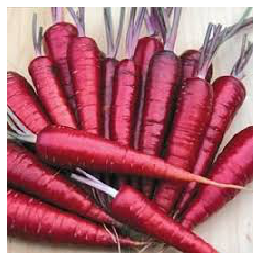

In [23]:
# Test Case:1 - ORGANIC

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('../input/waste-classification-data/DATASET/TEST/O/O_12650.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

The image belongs to Recycle waste category


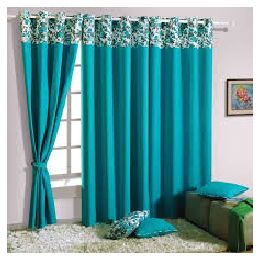

In [24]:
# Test Case:2 - RECYCLE

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('../input/waste-classification-data/DATASET/TEST/R/R_10012.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_proba(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

In [28]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# load the saved model
model = load_model('/kaggle/working/best_weights.hdf5')

# load the image to be predicted
img_path = '../input/waste-classification-data/DATASET/TEST/R/R_10012.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# make the prediction
pred = model.predict(x)
if pred[0][0] > 0.5:
    print("The image belongs to class 0")
else:
    print("The image belongs to class 1")


The image belongs to class 0


In [1]:
import pickle

def predict(model_path, img_path):
    from keras.models import load_model
    from keras.preprocessing import image
    import numpy as np

    # load the saved model
    model = load_model('/kaggle/working/best_weights.hdf5')

    # load the image to be predicted
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # make the prediction
    pred = model.predict(x)
    if pred[0][0] > 0.5:
        return "The image belongs to class 0"
    else:
        return "The image belongs to class 1"

# pickle the predict function
with open('model_prediction.pkl', 'wb') as f:
    pickle.dump(predict, f)

# load the pickled predict function
with open('model_prediction.pkl', 'rb') as f:
    predict_fn = pickle.load(f)

# use the loaded predict function to make a prediction
img_path = '../input/waste-classification-data/DATASET/TEST/R/R_10012.jpg'
result = predict_fn('/kaggle/working/best_weights.hdf5', img_path)
print(result)


The image belongs to class 0


### CONCLUSION

> `1. We were able to classify images properly having accuracy of 97.00% in training dataset.`

> `2. We acheived an accuracy of 95.60% on validation data and 94.98% accuracy on test accuracy.`